In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.names

--2020-12-25 12:17:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402355 (393K) [application/x-httpd-php]
Saving to: ‘arrhythmia.data’

arrhythmia.data     100%[===================>] 392.92K  --.-KB/s    in 0.1s    

2020-12-25 12:17:21 (2.72 MB/s) - ‘arrhythmia.data’ saved [402355/402355]

--2020-12-25 12:17:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6162 (6.0K) [application/x-httpd-php]
Saving to: ‘arrhythmia.names’

arrhythmia.names    100%[===================>]   6.02K

In [2]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 8.9MB/s 
     |████████████████████████████████| 22.2MB 60.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
from matplotlib import rcParams
matplotlib_style = 'fivethirtyeight'
plt.style.use(matplotlib_style)
rcParams['figure.figsize'] = (12, 8)
np.set_printoptions(linewidth=180)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN, RandomOverSampler
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
with open('arrhythmia.names', 'r') as file:
    names = file.readlines()
    
attridute_idx_start = names.index('7. Attribute Information:\n')
attridute_idx_end = names.index("8. Missing Attribute Values: Several.  Distinguished with '?'.\n")
class_idx_start = names.index('9. Class Distribution:\n')

str_list = [list(filter(None, line.strip().split(sep='\t')))for line in names[class_idx_start+3:-1]]

In [5]:
data_words = re.compile(r"\s{2,}")

def class_dist_preper(str_):
    ans = data_words.split(str_[0])
    if len(str_) > 1: 
       ans.append(str_[1].strip())
    return ans


In [6]:
col_names = re.findall(r'(\w+\s?.+?\s?:)+', str_list[0][0])
col_names

['Class code :', 'Class   :', 'Number of instances:']

In [7]:
ground_true_class_dist = pd.DataFrame(list(map(class_dist_preper, str_list[1:])), columns=col_names)
ground_true_class_dist

,Class code :,Class :,Number of instances:
0,01,Normal,245
1,02,Ischemic changes (Coronary Artery Disease),44
2,03,Old Anterior Myocardial Infarction,15
3,04,Old Inferior Myocardial Infarction,15
4,05,Sinus tachycardy,13
5,06,Sinus bradycardy,25
6,07,Ventricular Premature Contraction (PVC),3
7,08,Supraventricular Premature Contraction,2
8,09,Left bundle branch block,9
9,10,Right bundle branch block,50


In [8]:
text_spliter = re.compile(r',|:')
digit_extactor = re.compile(r'\d+')
def line_prep(arr):
    ans = re.split(text_spliter, arr)
    f_num = re.findall(digit_extactor, ans[0])
    f_num.append(re.sub(digit_extactor, '', ans[0], ))
    f_num.extend(ans[1:])

    return f_num 


In [9]:
cols = list(filter(None, [str_.strip() for str_ in names[attridute_idx_start + 2:attridute_idx_end]]))

In [10]:
vector_idx = cols.index([name for name in cols if name.startswith('Vector')][0])
end_idx = cols.index([name for name in cols if name.startswith('15')][0])
cols[vector_idx + 1:end_idx] = [' '.join([line + ':', cols[vector_idx]]) for line in cols[vector_idx + 1:end_idx]]

In [11]:
start_idx = cols.index([name for name in cols if name.startswith('Average')][0])
end_idx = cols.index([name for name in cols if name.startswith('21')][0])
cols[start_idx + 1:end_idx] = [' '.join([line + ':', cols[start_idx]]) for line in cols[start_idx + 1:end_idx]]

In [12]:
template = np.empty((12, 4),dtype='object')

In [13]:
start_idx = cols.index([name for name in cols if name.startswith('16')][0])
end_idx = cols.index([name for name in cols if name.startswith('27')][0])
for i, line in enumerate(cols[start_idx:end_idx + 1]):
    x = line_prep(line)
    if len(x) > 4:
        template[i, :2] = x[:2]
        template[i, 2:-1] =  ' '.join(x[2:-1])
        template[i, -1] = x[-1]
    else:
        template[i, 0] = x[0]
        template[i, 2:] = x[1:]


In [14]:
template1 = np.empty((10, 4), dtype='object')

start_idx = cols.index([name for name in cols if name.startswith('160')][0])
end_idx = cols.index([name for name in cols if name.startswith('168')][0])

for i, line in enumerate(cols[start_idx : end_idx]):
    x = line.split()
    x1, x2 = x.pop(1), x.pop(1)
    name = ' '.join([x1, x2])
    disc = ' '.join([cols[start_idx - 1], name])
    x.insert(1, name)
    x.insert(2, disc)
    template1[i, :] = np.array(x)

start_idx = cols.index([name for name in cols if name.startswith('168')][0])
end_idx = cols.index([name for name in cols if name.startswith('169')][0]) 

str_1 = re.sub(r', \(', ' ', ' '.join(cols[start_idx:end_idx]))
str2 = re.sub(r' =', ':', ' '.join(cols[end_idx:end_idx + 3]))
cols[start_idx] = re.sub(r', \(', ' ', ' '.join(cols[start_idx:end_idx]))
cols[end_idx] = re.sub(r' =', ':', ' '.join(cols[end_idx:end_idx + 3]))

template1[8,:] = np.array(line_prep(str_1))
template1[9,:] = np.array(line_prep(str2))


In [15]:
template[:,0] = template[:,0].astype(np.int16)
template1[:,0] = template1[:,0].astype(np.int16)


In [16]:
common_cols = [name for name in cols if name[0].isdigit()  and '..' in name]
common_cols[0] = re.split(r'\(', common_cols[0])[0]

In [17]:
arr_list = []
for i, col in enumerate(common_cols):
    x = list(map(int, re.findall(r'\d+', col)))
    col_muns = np.arange(x[0], x[1]+1)

    arr_i = template1.copy() if x[1] > 160 else template.copy()
    arr_i[:, 0] = col_muns
    arr_list.append(arr_i)
    
arr1 = np.vstack(arr_list)

In [18]:
arr0 = np.empty((15, 4), dtype='object')
end_idx = cols.index([name for name in cols if name.startswith('15')][0]) +1
x = list(map(line_prep, cols[:end_idx])) 
for i, line in enumerate(x):
    line = list(filter(None, line))
    if line[0] in ['6', '7']:
        line[:2].extend(' '.join([line[-1], x[i+1][0]]))
        line.append(x[i+1][1])
        arr0[int(line[0])-1, :] = np.array(line)
    elif line[0].isdigit():
        arr0[int(line[0])-1, :] = np.array(line)
     
arr0[:,0] = arr0[:,0].astype(np.int16)

In [19]:
f = lambda x: x.strip()
vf = np.vectorize(f)

total_info = np.vstack([arr0, template, arr1, template1])
total_info[:, 0] = total_info[:, 0] -1
total_info  = total_info[total_info[:,0].argsort()]

total_info[:, 1] = ['feature_' + str(i) for i in range(total_info.shape[0])]

total_info[:, -1] = vf(total_info[:, -1])

total_info.shape

(279, 4)

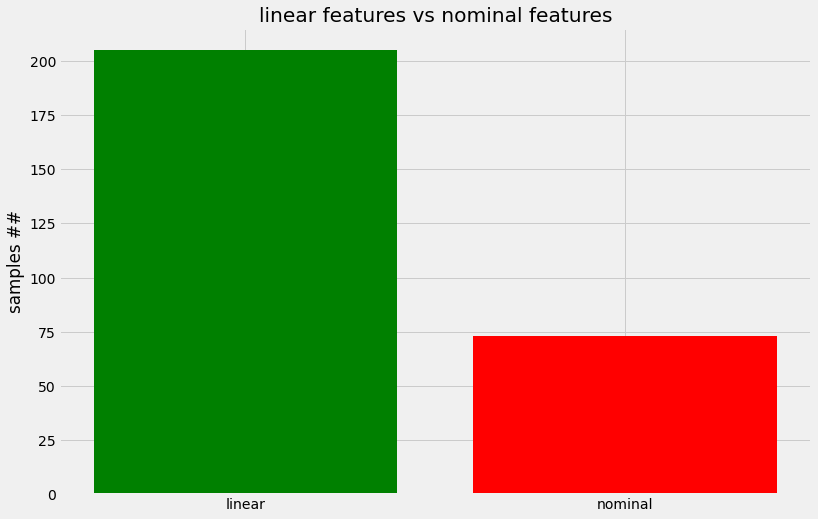

In [20]:
val, count = np.unique(total_info[:-1, -1], return_counts=True)
plt.bar(val, count, color=['g', 'r']);
plt.title("linear features vs nominal features")
plt.ylabel("samples ##");

In [21]:
names=total_info[:,1].tolist()
names.append('target')
data = pd.read_csv('arrhythmia.data', header=None, index_col=None, names=names)
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,target
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,?,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,?,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,?,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13,61,3,?,?,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


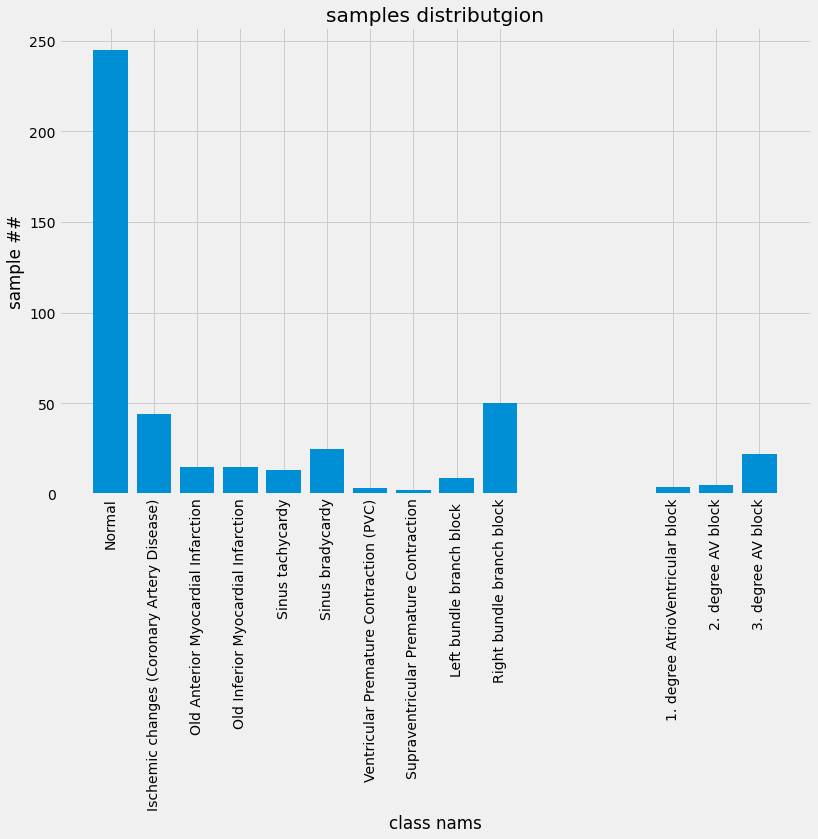

In [22]:
val, count = np.unique(np.array(data['target']), return_counts=True)
plt.bar(val, count)
plt.xticks(ticks=val,labels=ground_true_class_dist['Class   :'],  rotation='vertical');
plt.ylabel("sample ##")
plt.xlabel("class nams");
plt.title("samples distributgion");

In [23]:
cols_to_drop = data.columns[(data == 0).all()]

cat_cols = [ col for col in total_info[total_info[:, -1]=='nominal', 1].tolist() if not col in cols_to_drop]
num_cols = [col for col in total_info[total_info[:, -1]=='linear', 1].tolist() if not col in cols_to_drop]

data.drop(columns=cols_to_drop, inplace=True)

In [24]:
obj_col = data.select_dtypes(include='object').columns
data[obj_col].head()

,feature_10,feature_11,feature_12,feature_13,feature_14
0,13,64,-2,?,63
1,37,-17,31,?,53
2,34,70,66,23,75
3,11,-5,20,?,71
4,13,61,3,?,?


In [25]:
data[obj_col]  = data[obj_col].replace('?', np.nan).astype(np.float64)
data[obj_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_10  444 non-null    float64
 1   feature_11  430 non-null    float64
 2   feature_12  451 non-null    float64
 3   feature_13  76 non-null     float64
 4   feature_14  451 non-null    float64
dtypes: float64(5)
memory usage: 17.8 KB


In [26]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())
                                      ])


In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [28]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_transformed = preprocessor.fit_transform(X)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [30]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [31]:
def model_evalute(model, train, y_t=y_train, test=X_test, y_tst=y_test):
    model.fit(train, y_t)
    y_pred = model.predict(test)
    print('accuracy: ', accuracy_score(y_tst, y_pred))
    print('precision: ', precision_score(y_tst, y_pred, labels=np.unique(y_pred), average='macro'))
    print('recall: ', recall_score(y_tst, y_pred, labels=np.unique(y_pred), average='macro'))
    print('f1: ', f1_score(y_tst, y_pred, labels=np.unique(y_pred), average='macro'))

In [32]:
%%time
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
print("score on development set: ")
print('accuracy: ', np.mean(cross_val_score(neigh, X_train, y_train, cv=kf, scoring='accuracy')))
print('precision: ', np.mean(cross_val_score(neigh, X_train, y_train, cv=kf, scoring='precision_macro')))
print('recall: ', np.mean(cross_val_score(neigh, X_train, y_train, cv=kf, scoring='recall_macro')))
print('f1: ', np.mean(cross_val_score(neigh, X_train, y_train, cv=kf, scoring='f1_macro')))

score on development set: 
accuracy:  0.6398401826484019


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Pr

precision:  0.4811197808683441
recall:  0.34954829682102406
f1:  0.360202540535906
CPU times: user 466 ms, sys: 1.96 s, total: 2.42 s
Wall time: 2.23 s


In [33]:
%%time
print("score on test set: ")
model_evalute(neigh, X_train)

score on test set: 
accuracy:  0.6153846153846154
precision:  0.6932234432234432
recall:  0.5481373501781664
f1:  0.5536888308541851
CPU times: user 38.3 ms, sys: 93 ms, total: 131 ms
Wall time: 127 ms


In [34]:
%%time
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
print("score on development set with balanced clases : ")
print('accuracy: ', np.mean(cross_val_score(neigh, X_res, y_res, cv=kf, scoring='accuracy')))
print('precision: ', np.mean(cross_val_score(neigh, X_res, y_res, cv=kf, scoring='precision_macro')))
print('recall: ', np.mean(cross_val_score(neigh, X_res, y_res, cv=kf, scoring='recall_macro')))
print('f1: ', np.mean(cross_val_score(neigh, X_res, y_res, cv=kf, scoring='f1_macro')))

score on development set with balanced clases : 
accuracy:  0.9646742940791248
precision:  0.96414423255193
recall:  0.9652314392757957
f1:  0.9620577791764436
CPU times: user 2.54 s, sys: 2.22 s, total: 4.75 s
Wall time: 3.05 s


In [35]:
%%time
print("score on test set with balanced clases: ")
model_evalute(neigh, X_res, y_t=y_res)

score on test set with balanced clases: 
accuracy:  0.5714285714285714
precision:  0.43073593073593064
recall:  0.5152752009894868
f1:  0.459573002754821
CPU times: user 58.2 ms, sys: 91.8 ms, total: 150 ms
Wall time: 128 ms


In [36]:
# метод опорных векторов (лучшее ядро - linear) до балансировки классов
%%time
clf = SVC(C = 0.1, kernel='linear', random_state=241)
print("score on development set: ")
model_evalute(clf, X_train, test=X_train, y_tst=y_train)

score on development set: 
accuracy:  0.9806094182825484
precision:  0.9957807118254879
recall:  0.9767442874585732
f1:  0.9851328255804133
CPU times: user 52 ms, sys: 7.13 ms, total: 59.1 ms
Wall time: 57.8 ms


In [37]:
# метод опорных векторов (лучшее ядро - linear) до балансировки классов
%%time
clf = SVC(C = 0.1, kernel='linear', random_state=241)
print("score on test set: ")
model_evalute(clf, X_train)

score on test set: 
accuracy:  0.7362637362637363
precision:  0.6298170383076044
recall:  0.6989692846835704
f1:  0.6492261178793686
CPU times: user 39.5 ms, sys: 794 µs, total: 40.3 ms
Wall time: 39.8 ms


In [38]:
# метод опорных векторов (лучшее ядро - linear) с балансировкой классов
%%time
clf = SVC(C = 0.01, kernel='linear', random_state=241)
print("score on development set with balanced clases : ")
model_evalute(clf, X_res, y_t=y_res,  test=X_res, y_tst=y_res)

score on development set with balanced clases : 
accuracy:  0.9870486656200942
precision:  0.9871652708004471
recall:  0.9870486656200941
f1:  0.9867721359375147
CPU times: user 392 ms, sys: 1.64 ms, total: 394 ms
Wall time: 406 ms


In [39]:
# метод опорных векторов (лучшее ядро - linear) с балансировкой классов
%%time
clf = SVC(C = 0.01, kernel='linear', random_state=241)
print("score on test set with balanced clases : ")
model_evalute(clf, X_res, y_t=y_res)

score on test set with balanced clases : 
accuracy:  0.7362637362637363
precision:  0.6535102578580839
recall:  0.738857967429396
f1:  0.6817377668770858
CPU times: user 145 ms, sys: 3.36 ms, total: 148 ms
Wall time: 150 ms


In [40]:
# бустинг на деревьях
%%time
clf = GradientBoostingClassifier(random_state=42, max_depth=5, warm_start=True)
print("score on development set: ")
model_evalute(clf, X_train, test=X_train, y_tst=y_train)

score on development set: 
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
CPU times: user 21.5 s, sys: 5.69 ms, total: 21.5 s
Wall time: 21.6 s


In [41]:
# бустинг на деревьях
%%time
clf = GradientBoostingClassifier(random_state=42, max_depth=5, warm_start=True)
print("score on test set: ")
model_evalute(clf, X_train)

score on test set: 
accuracy:  0.7252747252747253
precision:  0.6109982211275314
recall:  0.6914115646258503
f1:  0.6409146405733961
CPU times: user 21.5 s, sys: 6.82 ms, total: 21.5 s
Wall time: 21.6 s


In [42]:
# бустинг на деревьях c балансировкой
%%time
clf = GradientBoostingClassifier(random_state=42, max_depth=5)

print("score on development set with balanced clases : ")
model_evalute(clf, X_res, y_t=y_res, test=X_res, y_tst=y_res)

score on development set with balanced clases : 
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
CPU times: user 1min 26s, sys: 60.6 ms, total: 1min 26s
Wall time: 1min 26s


In [43]:
# бустинг на деревьях c балансировкой
%%time
clf = GradientBoostingClassifier(random_state=42, max_depth=5)
print("score on test set with balanced clases : ")
model_evalute(clf, X_res, y_t=y_res)

score on test set with balanced clases : 
accuracy:  0.7252747252747253
precision:  0.47401960784313724
recall:  0.569047619047619
f1:  0.5083977591036415
CPU times: user 1min 23s, sys: 144 ms, total: 1min 23s
Wall time: 1min 24s


In [44]:
# случайный лес
%%time
clf = RandomForestClassifier(n_estimators=350, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
print("score on development set: ")
model_evalute(clf, X_train, test=X_train, y_tst=y_train)

score on development set: 
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
CPU times: user 2.08 s, sys: 146 ms, total: 2.23 s
Wall time: 1.65 s


In [45]:
# случайный лес
%%time
clf = RandomForestClassifier(n_estimators=350, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
print("score on test set: ")
model_evalute(clf, X_train)

score on test set: 
accuracy:  0.6593406593406593
precision:  0.8233333333333333
recall:  0.698450491307634
f1:  0.6656844947167527
CPU times: user 2.02 s, sys: 135 ms, total: 2.16 s
Wall time: 1.65 s


In [46]:
# случайный лес
%%time
clf = RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1) # class_weight='balanced'
print("score on development set with balanced clases : ")
model_evalute(clf, X_res, y_t=y_res, test=X_res, y_tst=y_res)

score on development set with balanced clases : 
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
CPU times: user 4.02 s, sys: 138 ms, total: 4.15 s
Wall time: 2.47 s


In [47]:
# случайный лес
%%time
clf = RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1) # class_weight='balanced'
print("score on test set with balanced clases : ")
model_evalute(clf, X_res, y_t=y_res)

score on test set with balanced clases : 
accuracy:  0.6813186813186813
precision:  0.6952639751552795
recall:  0.5726757369614512
f1:  0.5661628096479792
CPU times: user 3.9 s, sys: 136 ms, total: 4.03 s
Wall time: 2.46 s


In [48]:
# деревья и леса
%%time
tr = DecisionTreeClassifier(random_state=42, class_weight='balanced')

print("score on development set: ")
model_evalute(tr, X_train, test=X_train, y_tst=y_train)

score on development set: 
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
CPU times: user 59 ms, sys: 1.03 ms, total: 60.1 ms
Wall time: 60.2 ms


In [49]:
# деревья и леса
%%time
tr = DecisionTreeClassifier(random_state=42, class_weight='balanced')

print("score on test set: ")
model_evalute(tr, X_train)

score on test set: 
accuracy:  0.5714285714285714
precision:  0.3969696969696969
recall:  0.4305916305916306
f1:  0.40235414740058706
CPU times: user 57.3 ms, sys: 0 ns, total: 57.3 ms
Wall time: 57.6 ms


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# деревья и леса
%%time
tr = DecisionTreeClassifier(random_state=42, class_weight='balanced')

print("score on development set with balanced clases : ")
model_evalute(tr, X_train, test=X_train, y_tst=y_train)

score on development set with balanced clases : 
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0
CPU times: user 63.9 ms, sys: 9 µs, total: 63.9 ms
Wall time: 68.4 ms


In [51]:
# деревья и леса
%%time
tr = DecisionTreeClassifier(random_state=42, class_weight='balanced')

print("score on test set with balanced clases : ")
model_evalute(tr, X_res, y_t=y_res)

score on test set with balanced clases : 
accuracy:  0.5604395604395604
precision:  0.36432806324110667
recall:  0.41224489795918373
f1:  0.37392880597214967
CPU times: user 142 ms, sys: 2.01 ms, total: 144 ms
Wall time: 146 ms


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
X_transformed.shape

(452, 326)

### wirh SVD and n fetures

In [53]:
parameters = [{'svd__n_components': np.hstack((range(2,11),range(20, 198, 10))),
               'clf__n_neighbors': range(3, 12)}]

pipeline = Pipeline([
    ('svd', TruncatedSVD(random_state=42)),
    ('clf', KNeighborsClassifier()) ])

In [54]:
%%time
gs = GridSearchCV( pipeline, parameters, scoring='accuracy')
gs.fit(X_train, y_train)

print("Best parameters set found on development set: ", gs.best_params_)
print("Best score found on development set: ", gs.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameters set found on development set:  {'clf__n_neighbors': 3, 'svd__n_components': 8}
Best score found on development set:  0.6482496194824962
CPU times: user 1min 13s, sys: 1min 16s, total: 2min 29s
Wall time: 1min 16s


In [55]:
%%time 
gs = GridSearchCV( pipeline, parameters, scoring='f1_macro')
gs.fit(X_res, y_res)

print("Best parameters set found on development set: ", gs.best_params_)
print("Best score found on development set: ", gs.best_score_)

Best parameters set found on development set:  {'clf__n_neighbors': 3, 'svd__n_components': 80}
Best score found on development set:  0.970349270432647
CPU times: user 5min 56s, sys: 5min 21s, total: 11min 18s
Wall time: 5min 51s


In [56]:
%%time 
svd = TruncatedSVD(8,)
X_train_ = svd.fit_transform(X_train)
X_test_ = svd.transform(X_test, )
clf = KNeighborsClassifier(n_neighbors=3)
print("score on test set: ")
model_evalute(clf, X_train_, test=X_test_)

score on test set: 
accuracy:  0.5494505494505495
precision:  0.3498015873015873
recall:  0.32700680272108845
f1:  0.32193526170798903
CPU times: user 35.3 ms, sys: 43.6 ms, total: 78.9 ms
Wall time: 46.5 ms


In [75]:
%%time
svd = TruncatedSVD(80,)
X_train_ = svd.fit_transform(X_train)
X_test_ = svd.transform(X_test, )
X_res_, y_res_ = ros.fit_resample(X_train_, y_train)
clf = KNeighborsClassifier(n_neighbors=3)
print("score on test set: ")
model_evalute(clf, X_res_, y_t= y_res_, test=X_test_)

score on test set: 
accuracy:  0.5934065934065934
precision:  0.5317460317460316
recall:  0.6343159486016628
f1:  0.5645852051512429
CPU times: user 82.2 ms, sys: 63.5 ms, total: 146 ms
Wall time: 97.4 ms
